# Topological Analysis of Immune Cell Subtypes Using Single-Cell RNA-seq

This notebook demonstrates the use of topological data analysis (TDA) methods—Mapper and persistent homology—on single-cell RNA-seq data from peripheral blood mononuclear cells (PBMCs).

In [1]:
# Run in local environment after activating conda env with required libraries
# e.g., conda activate tda_sc_env
import scanpy as sc
import kmapper as km
from kmapper import Cover
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
# from gtda.homology import VietorisRipsPersistence
# from gtda.plotting import plot_diagram
import matplotlib.pyplot as plt
import numpy as np

## Load and Preprocess PBMC 3k Dataset

In [13]:
# Load the PBMC 3k single-cell RNA-seq dataset
adata = sc.datasets.pbmc3k()

# Filter out genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Normalize total counts per cell
sc.pp.normalize_total(adata)

# Log-transform the data
sc.pp.log1p(adata)

# Identify the top 1000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

# Subset the data to only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scale each gene to unit variance and zero mean
sc.pp.scale(adata)

# Compute PCA with 20 components for UMAP and clustering later
sc.tl.pca(adata, n_comps=20)

# Compute the neighborhood graph of cells
sc.pp.neighbors(adata)

# Compute UMAP embedding
sc.tl.umap(adata, n_components=2)

# Cluster the cells using the Leiden algorithm
sc.tl.leiden(adata, resolution=0.5)

c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
adata.shape

(2700, 1000)

## Visualize Clusters and Marker Genes

### PCA

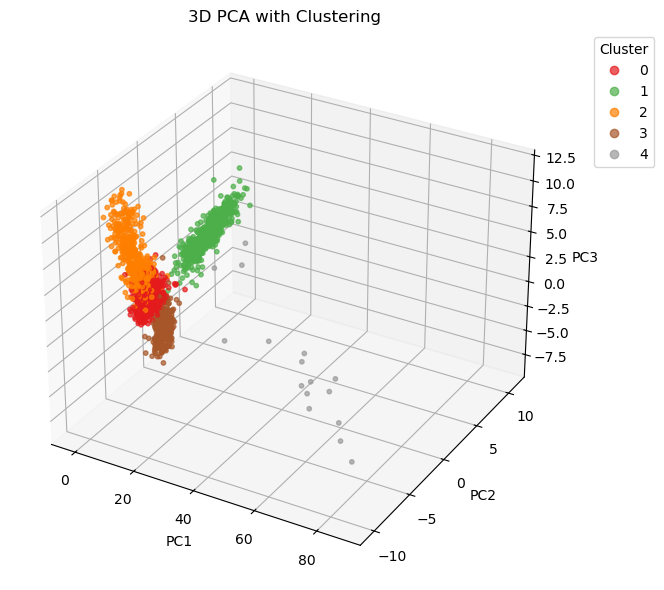

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# Extract first three principal components
pca_3d = adata.obsm['X_pca'][:, :3]
leiden_labels = adata.obs['leiden'].astype(int)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2],
    c=leiden_labels, cmap='tab10', s=10, alpha=0.7
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA with Clustering')

# Create legend
scatter.set_cmap('Set1') # Change color scheme to 'Set2'
handles, _ = scatter.legend_elements(prop="colors")
labels = sorted(adata.obs['leiden'].unique())

ax.legend(handles, labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

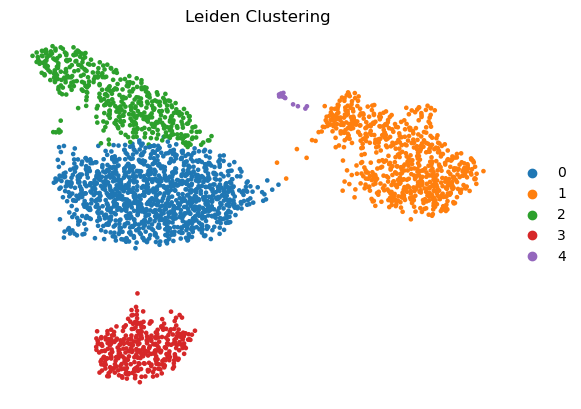

In [14]:
sc.pl.umap(adata, color='leiden', frameon=False, title='Leiden Clustering')

### Manually find the labels for the clusters
The highest scoring genes for each cluster will be used as the label. Note: t-test may not be the best (wilcoxon rank may be better)

c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\amish_mishra\AppData\Local\miniconda3\envs\tda_sc_env\Lib\site-packages\scanpy\tools\_rank_

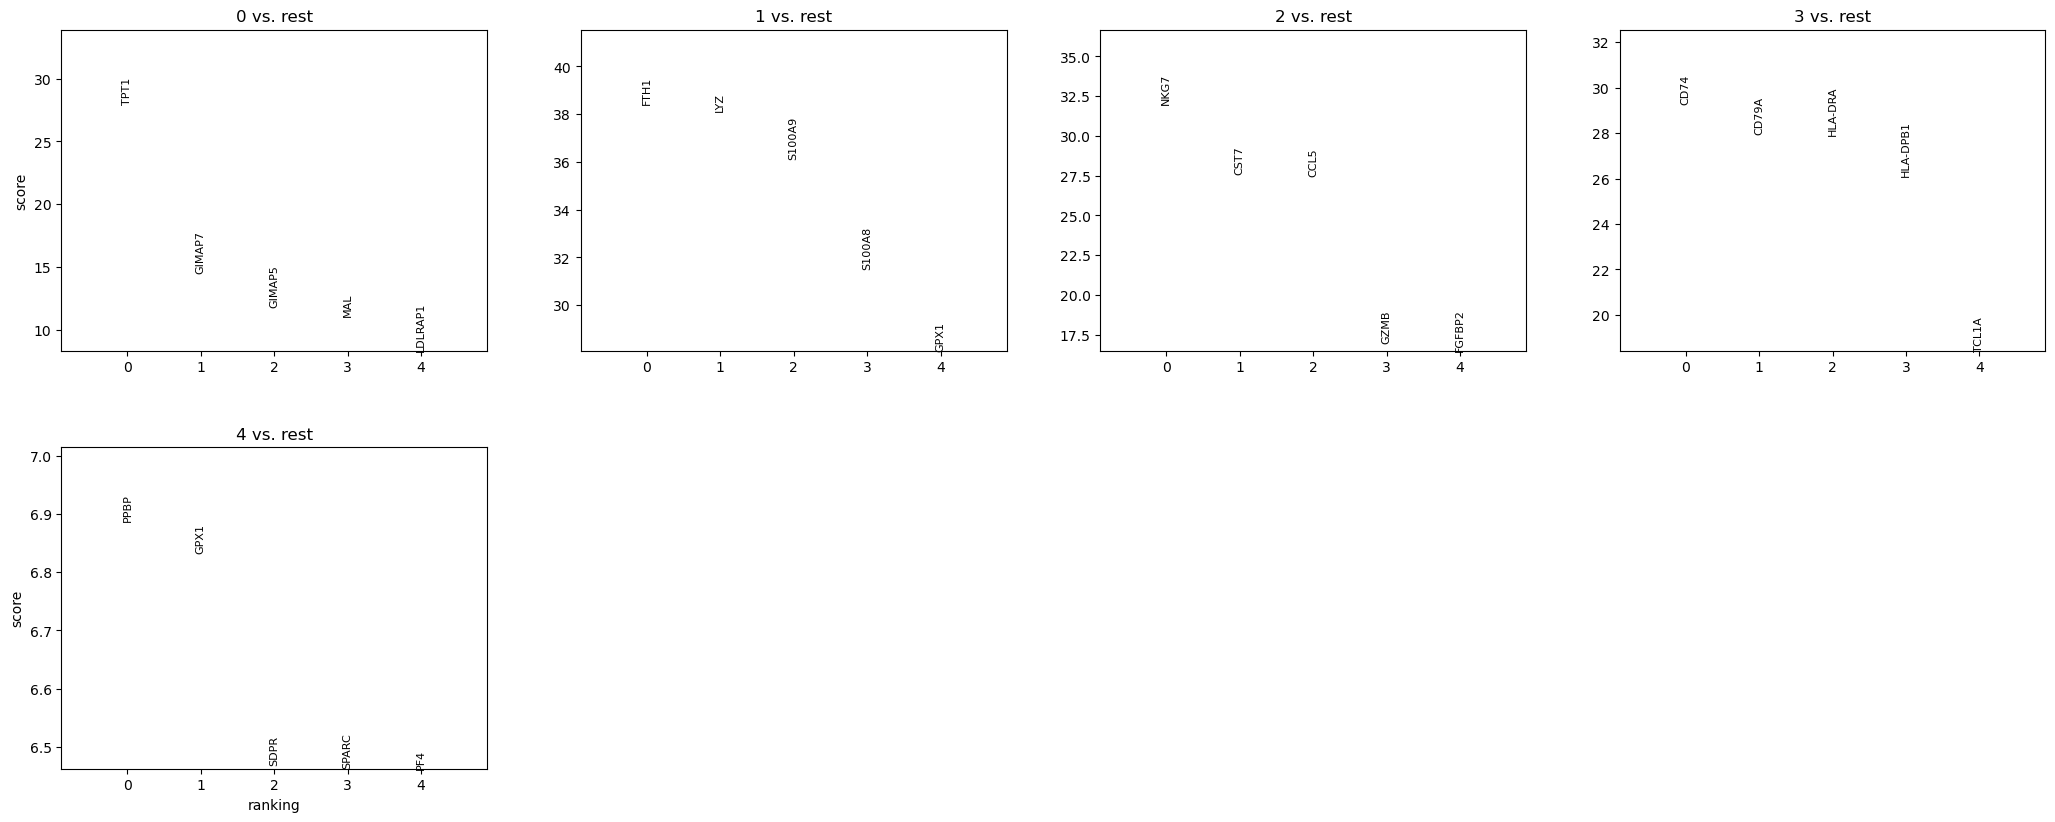

In [6]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', n_genes=5)
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

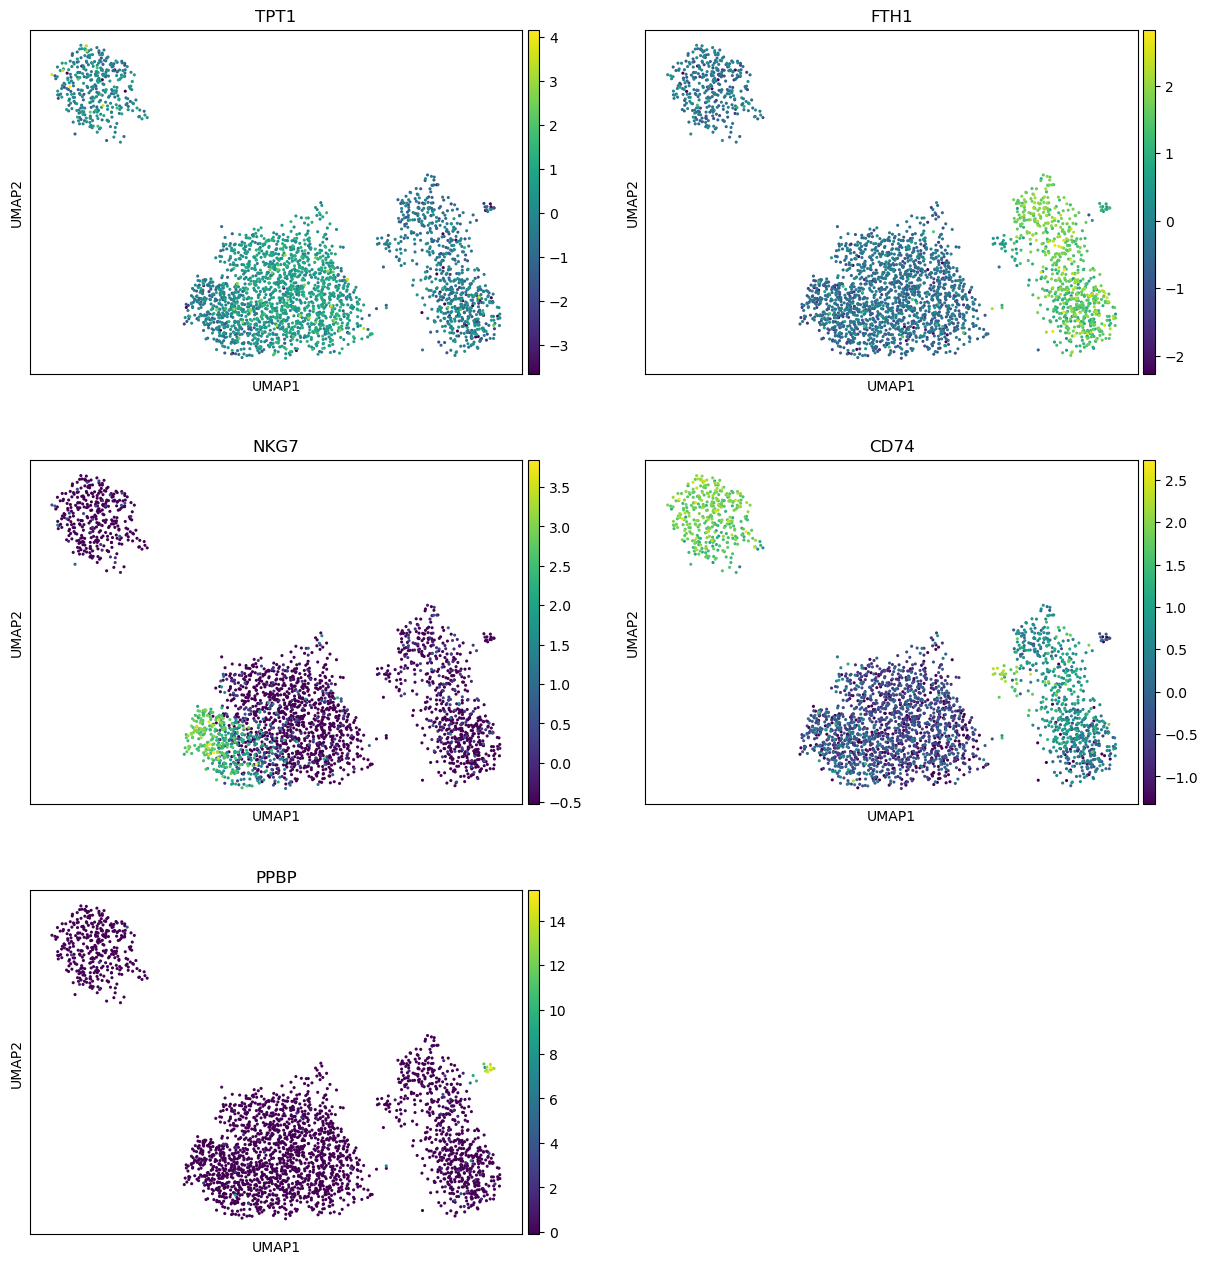

In [7]:
marker_genes = ["TPT1", "FTH1", "NKG7", "CD74","PPBP"]
sc.pl.umap(adata, color=marker_genes, cmap="viridis", size=20, ncols=2)

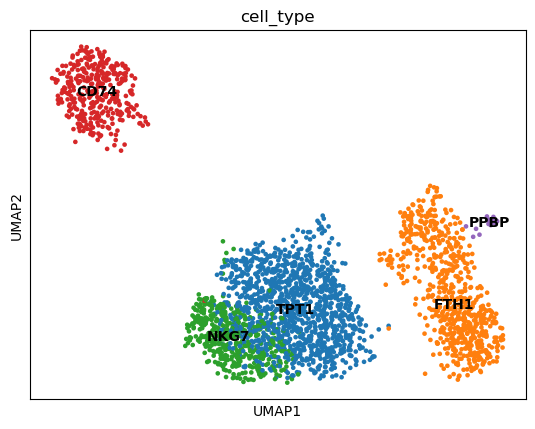

In [8]:
cluster_annotations = {
    "0": "TPT1",
    "1": "FTH1",
    "2": "NKG7",
    "3": "CD74",
    "4": "PPBP"
}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)
sc.pl.umap(adata, color='cell_type', legend_loc='on data')


## Summary Mapping (Biological Meaning)

| Cluster | Gene  | Likely Cell Type / State                     |
| ------- | ----- | -------------------------------------------- |
| 0       | TPT1  | Activated or stressed immune cells (general) |
| 1       | FTH1  | Monocytes or macrophages (iron metabolism)   |
| 2       | NKG7  | NK cells or CD8+ T cells (cytotoxic)         |
| 3       | CD74  | B cells / monocytes / dendritic cells        |
| 4       | PPBP  | Platelets or megakaryocytes                  |

---

### `"0": "TPT1"`

**TPT1** (Translationally-Controlled Tumor Protein 1)

* **Function**: Involved in cell growth, survival, and stress response.
* **Relevance in PBMCs**: Broadly expressed across many immune cell types.
* **Interpretation**: High TPT1 may suggest **cell activation or stress**, not specific to a particular cell type.

---

### `"1": "FTH1"`

**FTH1** (Ferritin Heavy Chain 1)

* **Function**: Regulates iron storage and detoxification.
* **Relevance in PBMCs**: Often expressed in **monocytes and macrophages**, which handle iron.
* **Interpretation**: Enrichment suggests this cluster could contain **monocytes** or **antigen-presenting cells**.

---

### `"2": "NKG7"`

**NKG7** (Natural Killer Cell Granule Protein 7)

* **Function**: Involved in cytotoxic granule exocytosis.
* **Relevance in PBMCs**: Highly expressed in **NK cells** and **CD8+ cytotoxic T cells**.
* **Interpretation**: Cluster 2 likely corresponds to **NK cells** or **CD8+ T cells**.

---

### `"3": "CD74"`

**CD74** (Invariant Chain for MHC Class II)

* **Function**: Assists antigen presentation via MHC class II.
* **Relevance in PBMCs**: Expressed in **B cells**, **monocytes**, and **dendritic cells**.
* **Interpretation**: Cluster 3 may include **antigen-presenting cells**, possibly **B cells** or **monocytes**.

---

### `"4": "PPBP"`

**PPBP** (Pro-Platelet Basic Protein, also known as CXCL7)

* **Function**: Chemokine involved in platelet activation and inflammation.
* **Relevance in PBMCs**: Highly expressed in **platelets** and **megakaryocytes**.
* **Interpretation**: Cluster 4 likely represents **platelets** or **megakaryocyte-derived cells**.

---

## Apply Kepler Mapper

In [17]:
# Compute UMAP embedding
sc.tl.umap(adata, n_components=4)

In [ ]:
low_dim_X = adata.obsm['X_umap']
mapper = km.KeplerMapper()
graph = mapper.map(
    low_dim_X, adata.X,
    cover=Cover(n_cubes=10, perc_overlap=0.3),
    clusterer=DBSCAN(eps=50, min_samples=3),
)

In [36]:
# Compute colorings for each marker gene and add them to the lens
marker_genes = ["TPT1", "FTH1", "NKG7", "CD74", "PPBP"]
colorings = [adata.X[:, adata.var_names.get_loc(gene)] for gene in marker_genes]
lens = np.c_[tuple(colorings)]

# Visualize Mapper graph with all marker gene colorings
mapper.visualize(
    graph,
    path_html="./results/mapper_graph.html",
    title="PBMC Mapper",
    color_values=lens,
    color_function_name=marker_genes,
)

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>PBMC Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weight:

## Biological Interpretation and Takeaways

- The Mapper graph highlights topological structure in cell-type space.
- Marker gene analysis helps assign biological meaning to Mapper nodes.

## 🧭 UMAP vs. Mapper: What's the Difference?

| Feature             | **UMAP**                                  | **Mapper (TDA)**                                |
| ------------------- | ----------------------------------------- | ----------------------------------------------- |
| Goal                | 2D visualization of high-dimensional data | Summarize **shape** and **structure** of data   |
| Output              | Coordinates in 2D space                   | A **graph**: nodes = regions, edges = overlap   |
| Interpretability    | Visual, but can **hide relationships**    | Explicit: connected regions capture transitions |
| Uses clustering?    | No (visual only)                          | Yes (cluster each bin, like zoomed-in views)    |
| Captures loops?     | Not reliably                              | ✅ Yes (e.g., cyclic or branching structure)     |
| Sensitive to layout | Yes (embedding choices matter)            | No (uses raw feature space or PCA)              |

---

## 🎯 So Why Use Mapper?

### 1. **Global Shape and Connectivity**

UMAP gives you a "flattened" 2D picture. But Mapper:

* **Preserves overlapping relationships** between regions
* Can show **branching**, **merging**, or **looping** structures (e.g., cell differentiation or cycle)
* Highlights **shared transitional states** (e.g., activation or exhaustion between clusters)

### 2. **Multiscale Views**

UMAP is **single-scale**: one layout.
Mapper is **multiscale**: you control the granularity via `n_cubes` and `overlap`.

> Like using a zoom lens that looks at local neighborhoods, but stitches them together based on overlap.

### 3. **Cluster + Topology Combined**

* Each **node** in Mapper is a **cluster of cells** (from a local view)
* Each **edge** shows shared cells between nodes
* This adds a layer of **structural reasoning** beyond pure distance

---

## 🧬 Example Use Case (Biology)

You have:

* **UMAP** showing 5 clusters.
* But **Mapper** might reveal that:

  * Cluster 2 and 3 are part of a **loop** (e.g., activation-inactivation cycle)
  * A rare node connects two otherwise distinct regions (a **transitional cell state**)

This is **biologically meaningful** and often **missed in UMAP**.

---

## 🧠 Think of it This Way:

| Analogy    | Description                                                              |
| ---------- | ------------------------------------------------------------------------ |
| **UMAP**   | A map of the city from a drone—pretty, intuitive, but 2D                 |
| **Mapper** | A subway map—abstract, but captures key **connectivity and transitions** |

---

## ✅ When to Use Mapper

Use Mapper **in addition to** UMAP when:

* You want to explore **rare, intermediate, or ambiguous populations**
* You're interested in **trajectory-like structure** without assuming a pseudotime
* You need a **discrete, interpretable graph** that supports downstream statistical comparison between cell groups

---

Would you like an example of something UMAP misses but Mapper detects (like a loop or a rare bridge population)?
